## Introducción

Este notebook tiene como propósito tomar el conjunto de datos `winequality-red.csv` e intentar desarrollar un modelo predictivo mediante un clasificador Naïve Bayes. El objetivo es predecir la calidad del vino en función de sus características químicas.

In [65]:
"""
Se había habilitado el Agg para poder guardar sin problemas la imágen de la curva ROC,
pero como ya está generada se comentará para poder ver los gráficos, si se quiere volver
a generar la curva ROC, se puede descomentar la línea. Quizás necesite reiniciarse el kernel o el entorno de ejecución.
"""
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from ydata_profiling import ProfileReport
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
import os

In [66]:
# Carga del dataset en un dataframe y visualizacion de los primeros 5 registros.
df = pd.read_csv("../data/winequality-red.csv", delimiter=";")
print(np.shape(df))  # este comando imprime la forma del dataframe
df.head(10)

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


## Análisis exploratorio de datos

En primera instancia se realiza un análisis mediante `ydata-profiling`, el cual genera un reporte completo del dataset, incluyendo estadísticas descriptivas, correlaciones, distribuciones de variables, etc. Este análisis es útil para entender la calidad de los datos y detectar posibles problemas como valores faltantes o outliers.

Las líneas están comentadas porque el reporte toma tiempo y ya está generado y guardado en la carpeta `output`. Pero si se quiere ejecutar basta con descomentar las líneas y ejecutar el bloque.

In [67]:
# Generación del reporte y guardado en un archivo HTML en la carpeta output.
#profile = ProfileReport(df, title="Red wine quality Report")
#profile.to_file("../output/red-wine-report.html")

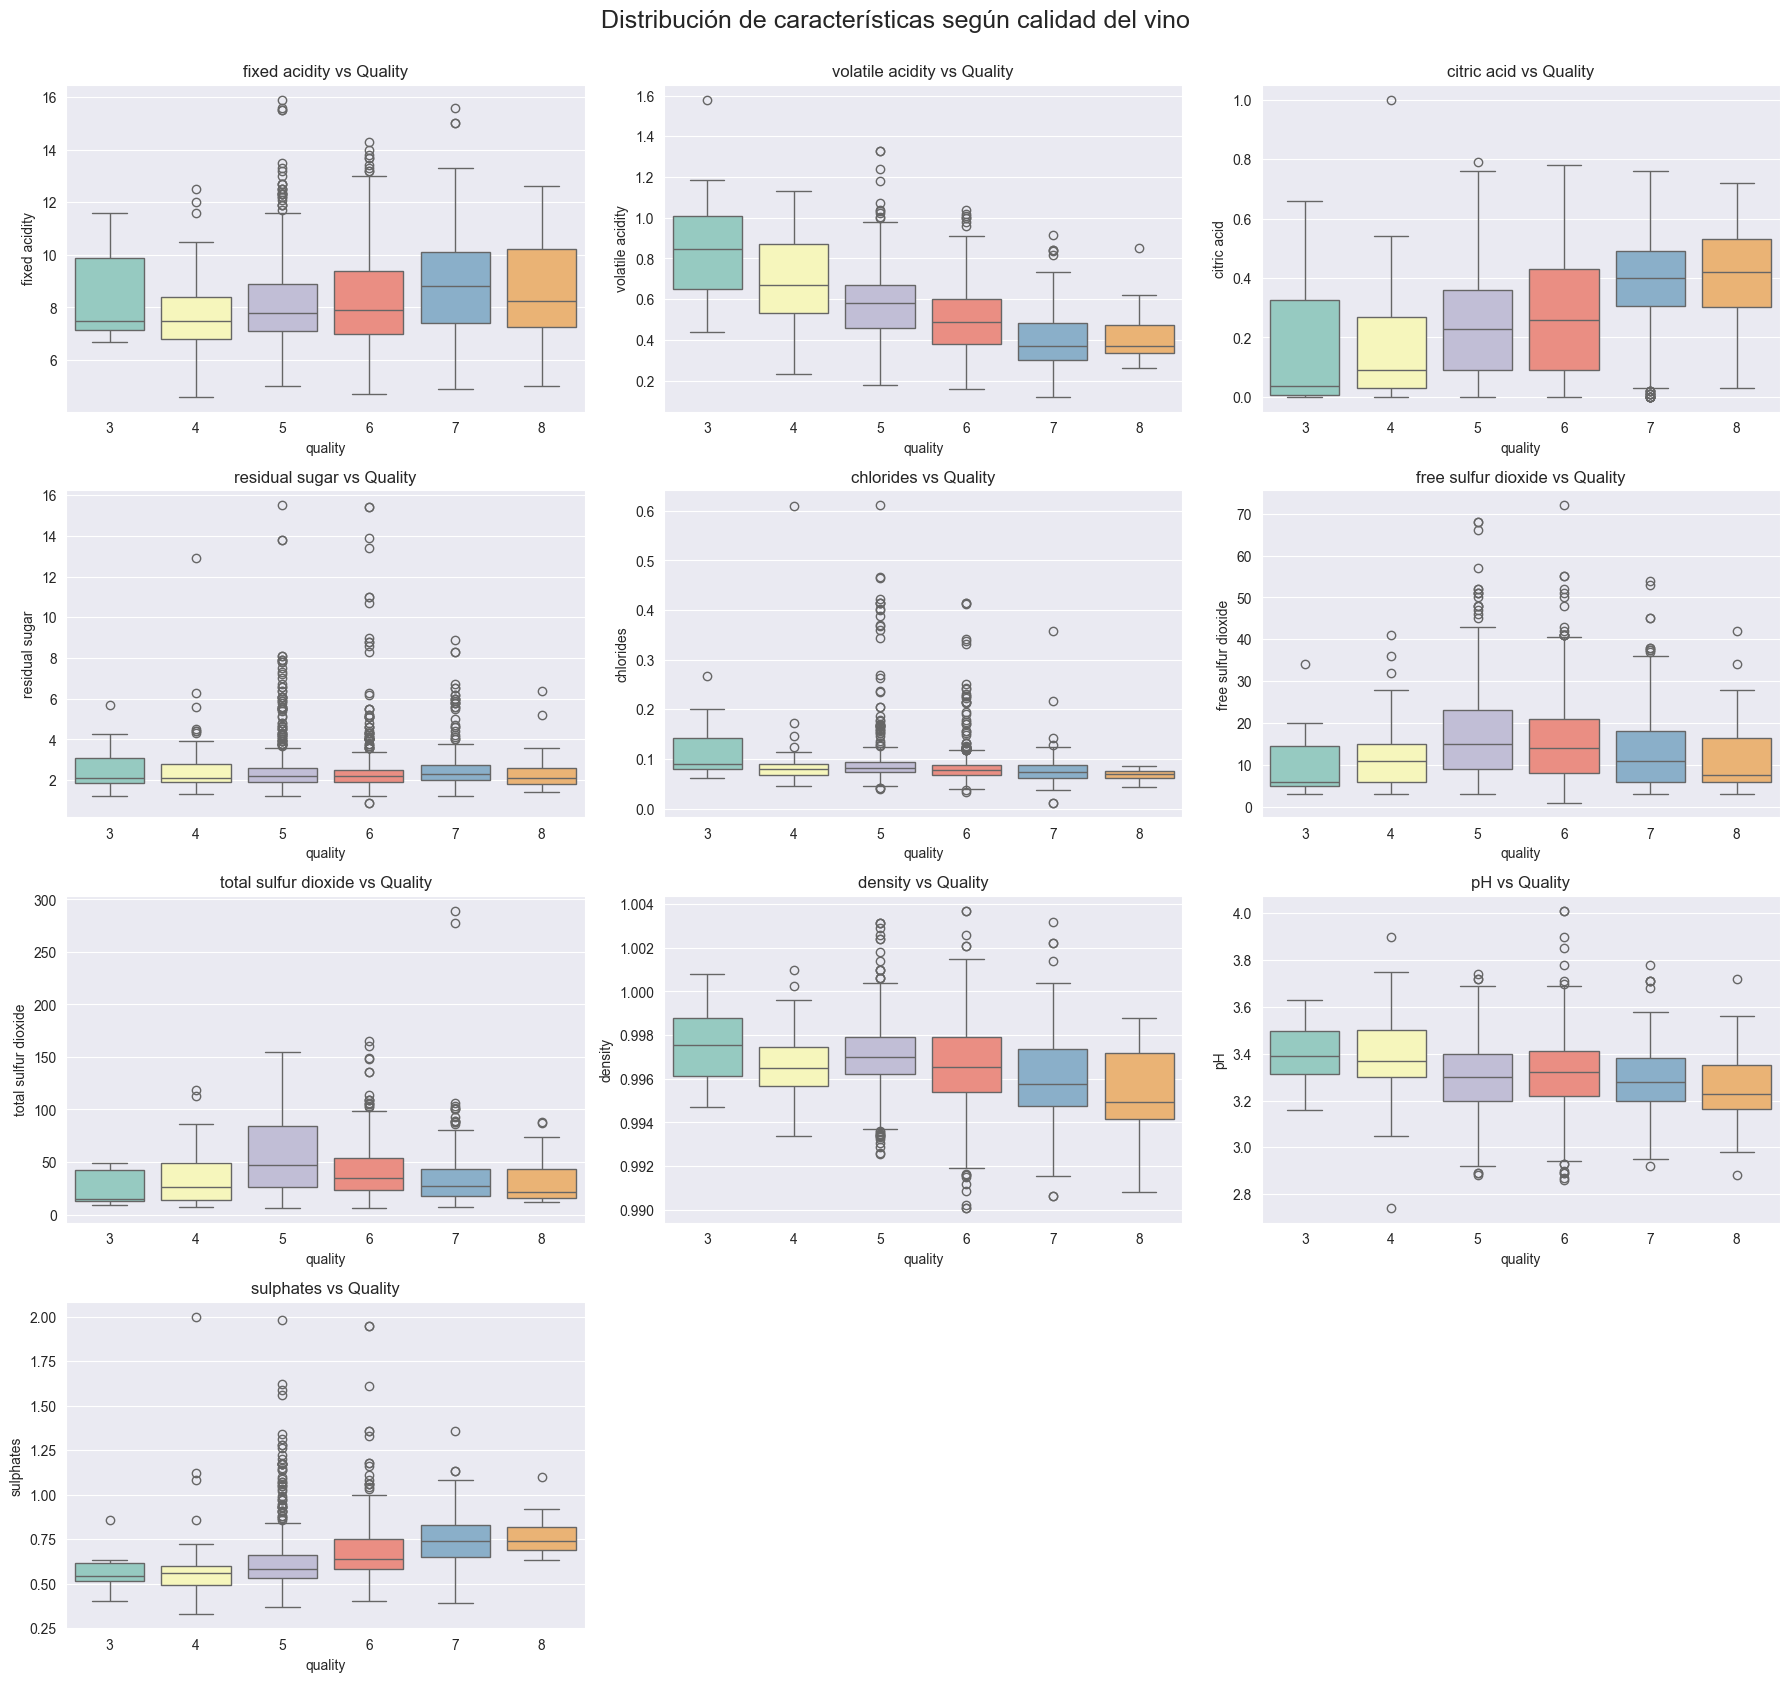

In [68]:
# Boxplot de cada variable por nivel de calidad
features = df.columns[:-2]  # excluye 'quality' y 'quality_label'
plt.figure(figsize=(18, 20))
for idx, col in enumerate(features):
    plt.subplot(5, 3, idx + 1)
    sns.boxplot(x='quality', y=col, data=df, hue='quality', palette='Set3', legend=False)
    plt.title(f'{col} vs Quality')
    plt.tight_layout()
plt.suptitle("Distribución de características según calidad del vino", fontsize=18, y=1.02)
plt.show()

In [ ]:
# TODO: Habría que limpiar los outliners porque son bastantes realmente.

C:\Users\edgar\AppData\Local\Temp\ipykernel_4960\330878267.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality', data=df, palette='Set2')


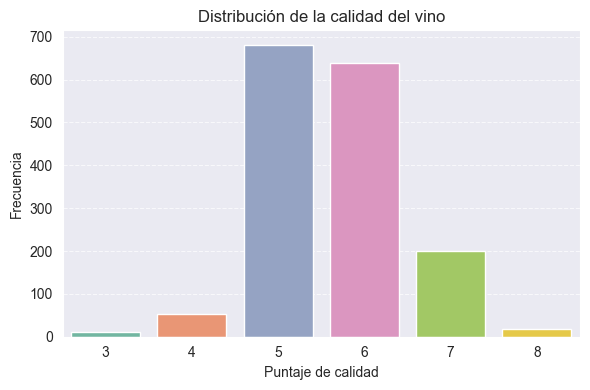

In [69]:
# Distribución de la calidad original (multiclase)
plt.figure(figsize=(6, 4))
sns.countplot(x='quality', data=df, palette='Set2')
plt.title("Distribución de la calidad del vino")
plt.xlabel("Puntaje de calidad")
plt.ylabel("Frecuencia")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

A modo de recomendación del profesor, se tienen los siguientes comentarios:
* Maneje los datos faltantes, si los hay. (con el reporte de ydata-profiling podemos ver que no hay datos faltantes, al igual que si vamos al [sitio oficial del conjunto de datos](https://archive.ics.uci.edu/dataset/186/wine+quality)) podemos ver que no hay missing values)
* Convierta la variable objetivo "quality" en una variable binaria: "low" (puntuación de calidad menor a 7) y "high" (puntuación de calidad mayor o igual a 7)
* Divida los datos en conjuntos de entrenamiento y prueba.

In [70]:
# Convertir la columna quality a binaria considerando como valor de corte 7, siendo menor a 7 'low' y mayor igual 7 'high'.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [71]:
# Crear la variable binaria 'quality_label'
df['quality_label'] = df['quality'].apply(lambda x: 'low' if x < 7 else 'high')

# Verificar la distribución de la nueva columna generada
print(df['quality_label'].value_counts())

quality_label
low     1382
high     217
Name: count, dtype: int64


C:\Users\edgar\AppData\Local\Temp\ipykernel_4960\2695964956.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality_label', data=df, palette='Set1')


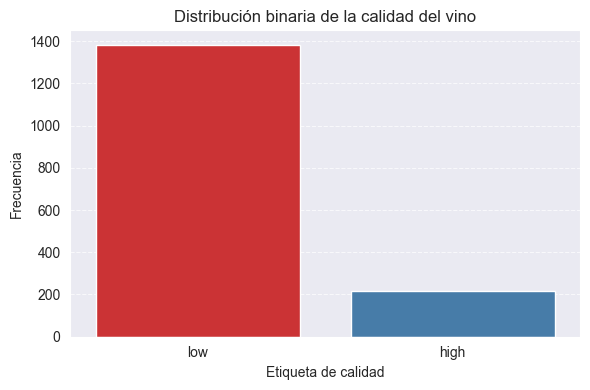

In [72]:
# Distribución de la calidad binaria (low/high)
plt.figure(figsize=(6, 4))
sns.countplot(x='quality_label', data=df, palette='Set1')
plt.title("Distribución binaria de la calidad del vino")
plt.xlabel("Etiqueta de calidad")
plt.ylabel("Frecuencia")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

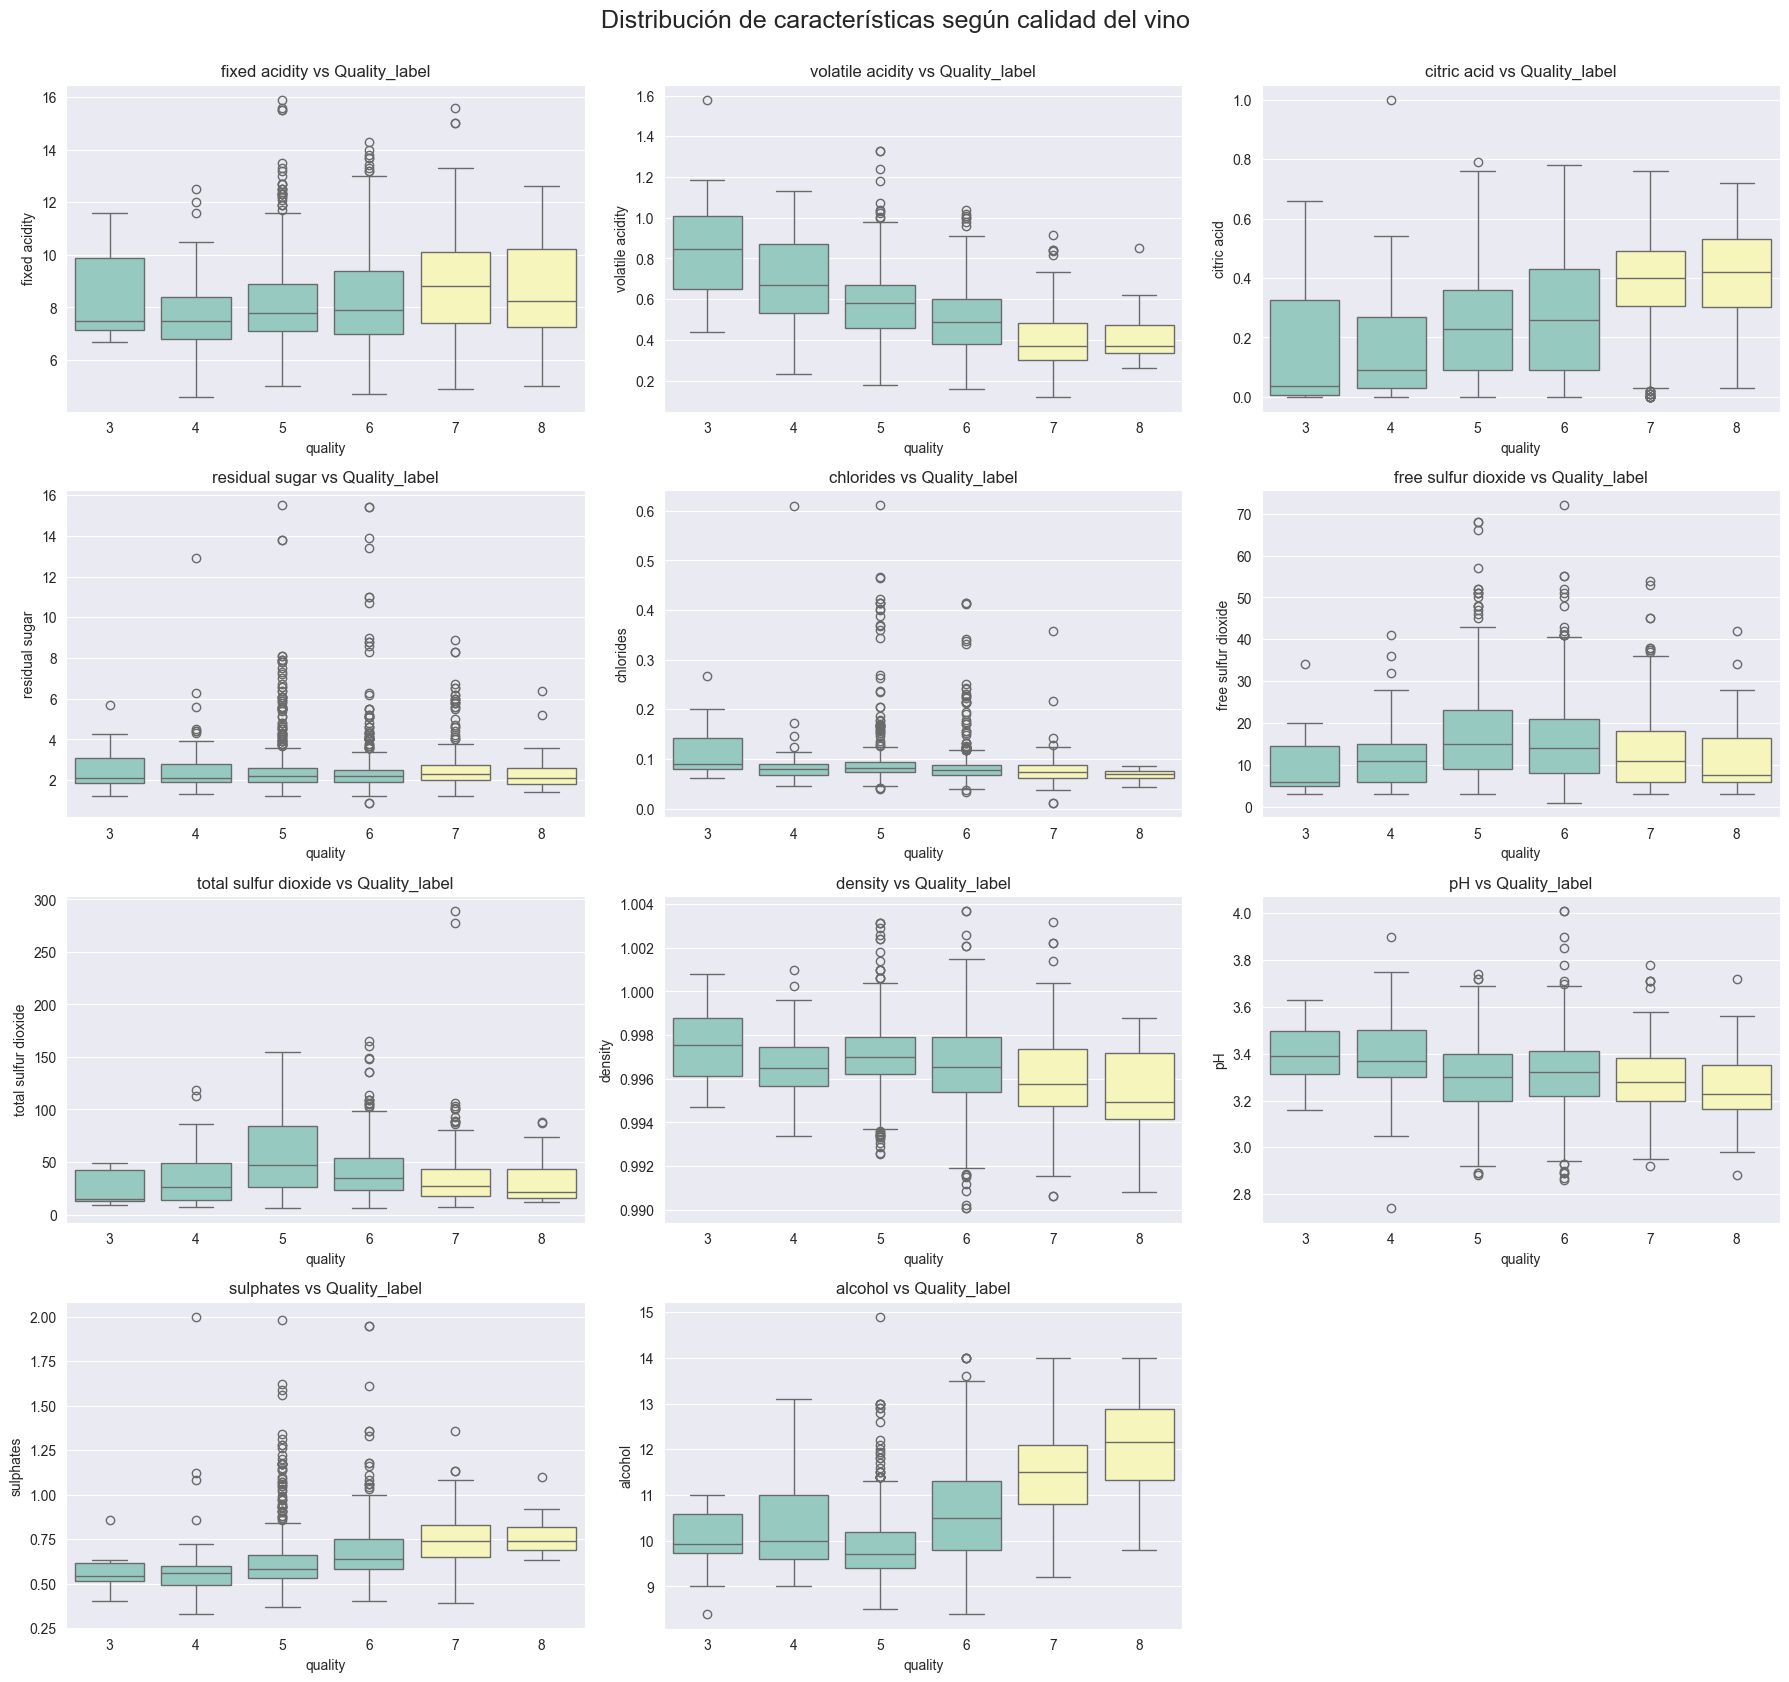

In [78]:
# Boxplot de cada variable por nivel de calidad
features = df.columns[:-2]  # excluye 'quality' y 'quality_label'
plt.figure(figsize=(18, 20))
for idx, col in enumerate(features):
    plt.subplot(5, 3, idx + 1)
    sns.boxplot(x='quality', y=col, data=df, hue='quality_label', palette='Set3', legend=False)
    plt.title(f'{col} vs Quality_label')
    plt.tight_layout()
plt.suptitle("Distribución de características según calidad del vino", fontsize=18, y=1.02)
plt.show()

## Preparación del conjunto de datos

Una vez realizado el análisis y la conversión de la variable objetivo, se procede a preparar el conjunto de datos para el entrenamiento del modelo. Esto incluye la separación de las características (X) y la variable objetivo (y), así como la división del conjunto de datos en conjuntos de entrenamiento y prueba.

In [73]:
# Separar las características (X) y la variable objetivo (y)
X = df.drop(['quality', 'quality_label'], axis=1)
y = df['quality_label']

# Codificar la variable objetivo (Naïve Bayes necesita etiquetas numéricas)
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # low=0, high=1

# División del dataset, la división quedó como 70% entrenamiento y 30% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

## Clasificador Naïve Bayes

El Clasificador Naïve Bayes recibe su nombre por estar basado en el Teorema de Bayes y por asumir, de manera ingenua, que las características (o variables predictoras) son independientes entre sí dadas las clases. Esta suposición de independencia simplifica enormemente los cálculos, aunque rara vez se cumple completamente en la práctica.

En términos generales, un clasificador bayesiano ingenuo asume que la presencia (o valor) de una característica no influye en la presencia de otra, lo que permite estimar la probabilidad de una clase de forma muy eficiente, incluso con pocos datos.
Los Clasificadores de Bayes se pueden entrenar facilmente y requieren de pocos datos para ser entrenados.

La fórmula del clasificador bayesiano es:
$$ P(C|X) = \frac{P(X|C)P(C)}{P(X)} $$

Donde:
* P(C∣X): probabilidad posterior de que un ejemplo con características X pertenezca a la clase C.

* P(X∣C): verosimilitud — probabilidad de observar X dado que la clase es CC.

* P(C): probabilidad a priori de la clase C.

* P(X): probabilidad total de observar el conjunto de características X.

In [74]:
# Instanciar el modelo
nb_model = GaussianNB()

# Entrenar el modelo con el conjunto de entrenamiento
nb_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = nb_model.predict(X_test)
print("Predicciones:",y_pred[0:20])
print("Real:",y_test[0:20])

Predicciones: [1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1]
Real: [1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1]


### Evaluación del Modelo

Después de realizar las predicciones sobre el conjunto de prueba, evaluamos el desempeño del modelo utilizando la **matriz de confusión** y métricas clave como *accuracy*, *precision*, *recall* y *F1-score*.

- **Matriz de confusión**: Muestra el desglose de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos.
  - Verdaderos positivos (TP): Predicciones correctas de la clase positiva.
  - Falsos positivos (FP): Predicciones incorrectas de la clase positiva.
  - Verdaderos negativos (TN): Predicciones correctas de la clase negativa.
  - Falsos negativos (FN): Predicciones incorrectas de la clase negativa.
- **Accuracy**: Proporción de predicciones correctas sobre el total.
- **Precision**: Mide cuántas de las instancias clasificadas como positivas realmente lo son.
- **Recall**: Indica qué proporción de verdaderos positivos fue correctamente identificada.
- **F1-score**: Media armónica (es el recíproco de la media aritmética) entre precision y recall.

In [75]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:\n", conf_matrix)

# Métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1-score: {f1:.2f}")


Matriz de confusión:
 [[ 44  21]
 [ 46 369]]
Accuracy: 0.86
Precision: 0.95
Recall: 0.89
F1-score: 0.92


## Curva ROC y análisis del Área bajo la curva (AUC)

Se calcula la curva ROC (Receiver Operating Characteristic) la cual es una representación gráfica que representa la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) a diferentes umbrales de clasificación. La curva ROC es útil para evaluar el rendimiento de un clasificador binario y su capacidad para discriminar entre las dos clases.

El Área bajo la curva (AUC) proporciona una medida agregada del rendimiento de este model en todos los umbrales de decisión posibles, un AUC de 0.5 indica un clasificador que no tiene capacidad de discriminación (equivalente a una clasificación aleatoria), mientras que un AUC de 1.0 indica un clasificador perfecto.

In [76]:
# Obtener probabilidades
y_proba = nb_model.predict_proba(X_test)[:, 1]  # Probabilidad de clase 'high'

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Crear la carpeta ../output si no existe
output_dir = "../output"
os.makedirs(output_dir, exist_ok=True)

# Ruta del archivo a guardar
output_path = os.path.join(output_dir, "roc_curve.png")

# Graficar y guardar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificador Naïve Bayes')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(output_path)
plt.close()

print(f"Curva ROC guardada en: {output_path}")

Curva ROC guardada en: ../output\roc_curve.png
